# Predicting RUL of EV Batteries

In this project, we apply Data Analysis and Machine Learning techniques to predict the **Remaining Useful Life (RUL)** of EV Batteries. We have used the Battery Degradation dataset available at the [Prognostic Centre of Excellence (PCoE)](http://ti.arc.nasa.gov/project/prognostic-data-repository).

In [1]:
%%capture
!pip install pymatreader
!pip install simple-colors
PATH = '/content/drive/Shareddrives/DS 203 Course Project/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing required libraries for loading and storing the data from the matlab datafiles
from pymatreader import read_mat
import pandas as pd

# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from simple_colors import *
sns.set()

### Data Description
4 Li-ion batteries were run through 3 operational profiles - charge, discharge and impedance at room temperature. 

1. Charging Profile - Each battery was charged a constant current (CC) of 1.5A till the battery voltage reached 4.2V. It was then charged in constant voltage (CV) mode until the charge current dropped to 20mA
2. Discharge Profile - Discharge was carried out at 2A CC until the battery voltage droped to 2.7V, 2.5V, 2.2V and 2.5V for each battery respectively
3. Impedance Profile - Used electrochemical impedance spectroscopy (EIS) sweeps from 0.1Hz to 5kHz

Each battery is subjected to 168 charge-discharge cycles which results in accelerated aging. The experiments were stopped once battery capacity diminished by 30% i.e. from 2 Ahr to 1.4 Ahr.

### Measurements
1. Charging fields
    * Battery terminal voltage (Volts) 
    * Battery output current (Amps)
    * Battery temperature (°C)
    * Current measured at charger (Amps)
    * Voltage measured at charger (Volts)
    * Measurement time stamps (secs)
    
    
2. Discharging fields
    * Battery terminal voltage (Volts) 
    * Battery output current (Amps)
    * Battery temperature (°C)
    * Current measured at load (Amps)
    * Voltage measured at load (Volts)
    * Measurement time stamps (secs)
    * **Battery capacity (Ahr) for discharge till 2.7V**

## Exploratory Data Analysis (EDA)

The data available is in a MATLAB structure and for ease of analysis, we use the [pymatreader](https://pypi.org/project/pymatreader/) module to load the data in Python. Data is separated into three dataframes for charge, discharge and impedance measurements respectively. 

Discharge data will be used for the purposes of RUL prediction while Impedance data will be used to explain the internal mechanisms resulting in battery degradation.

In [ ]:
data = read_mat(PATH + 'B0005.mat')
df = pd.DataFrame(data['B0005']['cycle'])

In [ ]:
df

,type,ambient_temperature,time,data
0,charge,24,"[2008.0, 4.0, 2.0, 13.0, 8.0, 17.921]","{'Voltage_measured': [3.873017221300996, 3.479..."
1,discharge,24,"[2008.0, 4.0, 2.0, 15.0, 25.0, 41.593]","{'Voltage_measured': [4.191491807505295, 4.190..."
2,charge,24,"[2008.0, 4.0, 2.0, 16.0, 37.0, 51.984]","{'Voltage_measured': [3.3250546568448542, 3.00..."
3,discharge,24,"[2008.0, 4.0, 2.0, 19.0, 43.0, 48.406]","{'Voltage_measured': [4.189773213846608, 4.188..."
4,charge,24,"[2008.0, 4.0, 2.0, 20.0, 55.0, 40.812]","{'Voltage_measured': [3.3526036599987754, 3.03..."
...,...,...,...,...
611,discharge,24,"[2008.0, 5.0, 27.0, 15.0, 52.0, 41.359]","{'Voltage_measured': [4.18482689434833, 4.1843..."
612,charge,24,"[2008.0, 5.0, 27.0, 17.0, 53.0, 59.765]","{'Voltage_measured': [3.7032033475672854, 3.33..."
613,discharge,24,"[2008.0, 5.0, 27.0, 20.0, 45.0, 42.125]","{'Voltage_measured': [4.201968615940368, 4.200..."
614,impedance,24,"[2008.0, 5.0, 27.0, 21.0, 34.0, 28.64]",{'Sense_current': [(839.7420654296875-31.55541...


Column **type** indicates what cycle is being experimented with. Column **ambient_temperature** contains the temperature in which the experiment was performed. 24 degrees is consistent with the dataset description. We can plot a histogram to check for variability in column **type** and **ambient_temperature**.

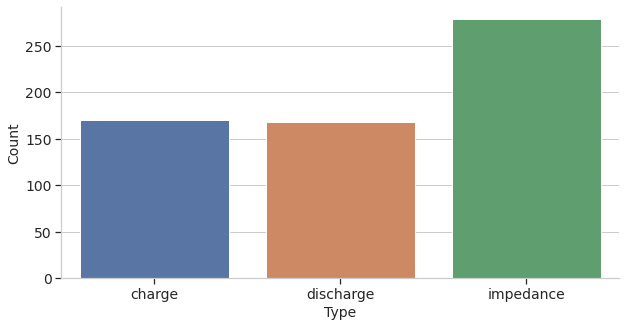

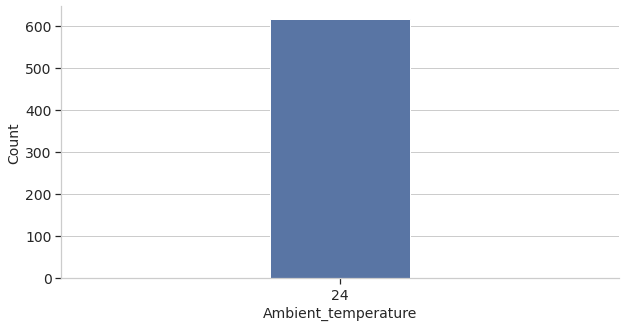

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
# Function to make a histogram plot for different columns in the data
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # Changing the bar width
        patch.set_width(new_value)

        # Recentering the bar
        patch.set_x(patch.get_x() + diff * .5)

def plot_histogram(df, col, width = 0):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data = df, x = col, dodge = False)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    # Change axis labels
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)
    if col == 'ambient_temperature': 
        plt.xlim()
    # Change tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if width != 0: change_width(ax, width)
    plt.show()

plot_histogram(df=df, col='type')
plot_histogram(df=df, col='ambient_temperature', width = 0.25)

In column **type**, charge and discharge are evenly distributed which is consistent with the fact that the battery is being charged then discharged. Column **ambient_temperature** only contains 24 degrees which tells us the experimental conditions were consistent across multiple cycles. Note that ambient temperature is not the same as battery temperature. 

Column **time** contains the experiment start time in MATLAB date time format (YYYY-mm-dd-HH-mm-ss.s). It is clear that there was a time gap between the charge and discharge cycles during which the battery was rested. **Data** is the column of interest which contains information about each cycle in a list format. Although we will focus on discharge data to predict RUL, we will also plot the data in the charge and impedance cycles.

In [ ]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    data = read_mat(PATH + 'B00' + num + '.mat')
    df = pd.DataFrame(data['B00' + num]['cycle'])

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

In [ ]:
charge, discharge, impedance = split_data(cell_number = 5)

### Charging Cycle

We begin by plotting fields from the charging data for different cycles. This helps us understand the effects of battery degradation on charging performance.

In [ ]:
# List the types of measurements made in the charging cycle
print('Measurements made:', [charge.iloc[0]['data'].keys()])

# Printing the type of each key
for key in charge.iloc[0]['data'].keys():
  print(f'{key} is of type', type(charge.iloc[0]['data'][key]))

Measurements made: [dict_keys(['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_charge', 'Voltage_charge', 'Time'])]
Voltage_measured is of type <class 'numpy.ndarray'>
Current_measured is of type <class 'numpy.ndarray'>
Temperature_measured is of type <class 'numpy.ndarray'>
Current_charge is of type <class 'numpy.ndarray'>
Voltage_charge is of type <class 'numpy.ndarray'>
Time is of type <class 'numpy.ndarray'>


In [ ]:
# All the data is in numpy arrays so we also print the datatype
for key in charge.iloc[0]['data'].keys():
  print(f'{key} is of type', charge.iloc[0]['data'][key].dtype)

Voltage_measured is of type float64
Current_measured is of type float64
Temperature_measured is of type float64
Current_charge is of type float64
Voltage_charge is of type float64
Time is of type float64


We observe that every dictionary value is a Python list consisting of time series data of datatype float. **Time** gives the instants at which a measurement was made.

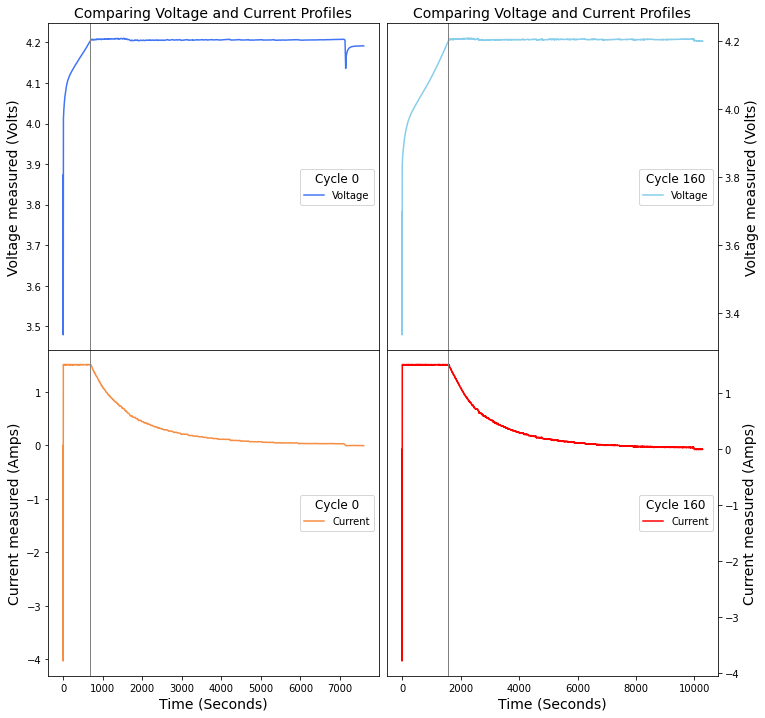

In [ ]:
sns.reset_orig()
# Plot voltage and current variation for the charging cycle
time0 = charge.iloc[0]['data']['Time'] # Measurement time samples for each run
voltage0 = charge.iloc[0]['data']['Voltage_measured']
current0 = charge.iloc[0]['data']['Current_measured']

time160 = charge.iloc[160]['data']['Time'] # Measurement time samples for each run
voltage160 = charge.iloc[160]['data']['Voltage_measured']
current160 = charge.iloc[160]['data']['Current_measured']

plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.025, hspace=0.0)

axes = []
for i in range(4): 
    axes.append(plt.subplot(gs[i]))
    axes[i].yaxis.tick_left()
    axes[i].grid(False)

# Plotting the required quantities in their respective positions 
# (cycle 0 quantities on the left and cycle 160 quantities on the right)

axes[0].plot(time0, voltage0, label='Voltage', color = '#4275f5')
axes[1].plot(time160, voltage160, label='Voltage', color = 'skyblue')

axes[2].plot(time0, current0, label='Current', color = '#f58d42')
axes[3].plot(time160, current160, label='Current', color = 'red')

# Setting appearance paramaters for the graphs in the top half
for i in [0,1]: 
    axes[i].set_title("Comparing Voltage and Current Profiles", fontsize = 14)
    axes[i].set_xticklabels([])
    axes[i].set_ylabel('Voltage measured (Volts)', fontsize = 14)    

# Setting appearance parameters for the graphs in the bottom half
for i in [2,3]: 
    axes[i].set_ylabel('Current measured (Amps)', fontsize = 14)
    axes[i].xaxis.tick_bottom()
    axes[i].set_xlabel('Time (Seconds)', fontsize = 14)

# Additional parameters for the left and right halves respectively
for i in [0,2]:
    axes[i].axvline(667.891, color = 'gray', linewidth = 1)
    axes[i].legend(title = "Cycle 0", loc = "center right", title_fontsize = 12)

for i in [1,3]:
    axes[i].yaxis.tick_right()
    axes[i].yaxis.set_label_position("right")
    axes[i].axvline(1578.844, color = 'gray', linewidth = 1)
    axes[i].legend(title = "Cycle 160", loc = "center right", title_fontsize = 12)

plt.show()

From the above plots, we confirm that the battery is being charged at constant current upto 4.2V after which it is charged at constant voltage as the current measured falls. Comparing plots between different cycles, we observe that the battery takes longer to charge as it degrades which is indicated by a longer time for the battery voltage to reach 4.2V. We do not explicitly plot the current and voltage measured at the charger since we expect the plots to be similar to what we see above.

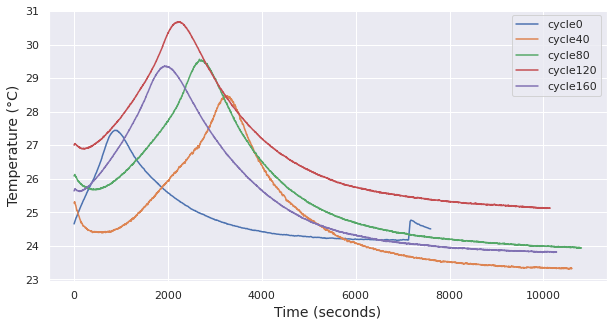

In [ ]:
sns.set()
# Temperature variation during charging cycle
plt.figure(figsize=(10, 5))

cycles = [0, 40, 80, 120, 160]
for cycle in cycles:
  time = charge.iloc[cycle]['data']['Time']
  data = charge.iloc[cycle]['data']['Temperature_measured']

  plt.plot(time, data, label=f'cycle{cycle}')
  plt.xlabel('Time (seconds)', fontsize=14)
  plt.ylabel('Temperature (°C)', fontsize=14)

plt.legend()
plt.show()

There doesn't seem to be a strong correlation between temperature in the charging cycle and battery degradation although the general trend is similar: temperature increases during the constant current phase and decreases in the constant voltage phase.

### Impedance Cycle

#### Background
Electrochemical impedance is measured by applying a small AC voltage over a wide-range of frequencies to a cell and measuring the current through it. The signal is kept small to ensure that the cell behaves pseudo-linearly. Impedance is a complex quantity and is specified by its magnitude and phase. 

From the dataset description, AC currents of frequencies between 0.1Hz and 5kHz are applied to estimate battery impedance. This is then used to obtain **Electrolytic** and **Charge-transfer** resistances at different stages of degradation. 

1. Electrolytic resistance is the resistance of the electrolyte
2. Charge-transfer resistance is the resistance faced by ions when they are transferred between different compounds in the cell.

In [ ]:
# List the types of measurements made in the charging cycle
print(f'Measurements made', impedance.iloc[0]['data'].keys())

# Printing the type of each key
for key in impedance.iloc[0]['data'].keys():
  print(f"{key} is of type", type(impedance.iloc[0]['data'][key]))

Measurements made dict_keys(['Sense_current', 'Battery_current', 'Current_ratio', 'Battery_impedance', 'Rectified_Impedance', 'Re', 'Rct'])
Sense_current is of type <class 'numpy.ndarray'>
Battery_current is of type <class 'numpy.ndarray'>
Current_ratio is of type <class 'numpy.ndarray'>
Battery_impedance is of type <class 'numpy.ndarray'>
Rectified_Impedance is of type <class 'numpy.ndarray'>
Re is of type <class 'float'>
Rct is of type <class 'float'>


_Sense_current_, _Battery_current_, _Current_ratio_, _Battery_impedance_, _Rectified_Impedance_ are numpy arrays while _Re_ (electrolytic resistance), _Rct_ (charge-transfer resistance) are float values. We also print the datatype of the numpy arrays to confirm that those quantities are complex numbers.

In [ ]:
# Printing the datatype of each key
for key in impedance.iloc[0]['data'].keys():
  if not (key == 'Re' or key == 'Rct'):
   print(f"{key} is of type", impedance.iloc[0]['data'][key].dtype)

Sense_current is of type complex128
Battery_current is of type complex128
Current_ratio is of type complex128
Battery_impedance is of type complex128
Rectified_Impedance is of type complex128


We move on to plot _Sense_current_, _Battery_current_, _Current_ratio_, _Battery_impedance_, _Rectified_Impedance_ for different runs while _Re_, _Rct_ are plotted as a function of runs since these are floating-point numbers.

In [ ]:
import cmath 

# Helper function for plotting impedance characteristics
def plot_impedance_characteristics(df, feature, runs=[0, 80, 160, 240]):
  plt.figure(figsize=(10, 5))
  # Plotting the magnitude for different runs
  for run in runs:
    data = df.iloc[run]['data'][feature]
    data_magnitude = np.abs(data)

    plt.plot(data_magnitude, label=f'run{run}')
    plt.legend()

  plt.title(f'{feature.replace("_", " ").title()} Magnitude plot', fontsize=16)
  plt.show()

  plt.figure(figsize=(10, 5))

  # Plotting the phase for different runs
  for run in runs:
    data = df.iloc[run]['data'][feature]
    data_phase = [cmath.phase(data[i]) for i in range(len(data))]

    plt.plot(data_phase, label=f'run{run}')
    plt.legend()

  plt.title(f'{feature.replace("_", " ").title()} Phase plot', fontsize=16)
  plt.show()

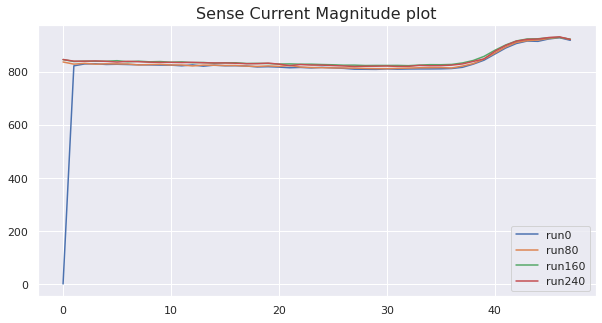

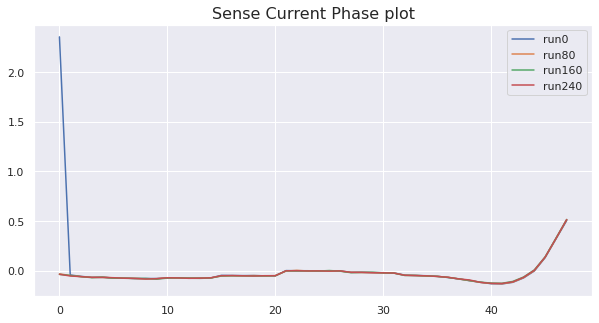

In [ ]:
plot_impedance_characteristics(impedance, 'Sense_current')

From the sense current magnitude plot, the magnitude of current applied for different frequencies is almost constant across different runs which is expected since measurements must be made under similar conditions. We repeat the above procedure for **battery current**.

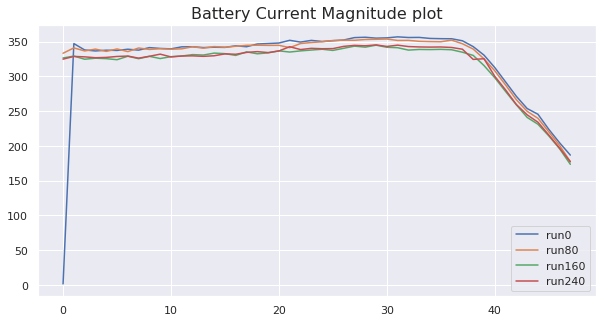

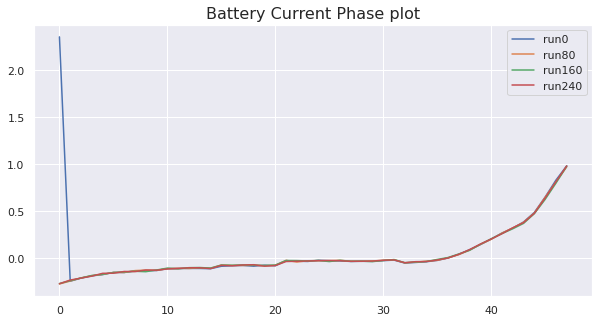

In [ ]:
plot_impedance_characteristics(impedance, 'Battery_current')

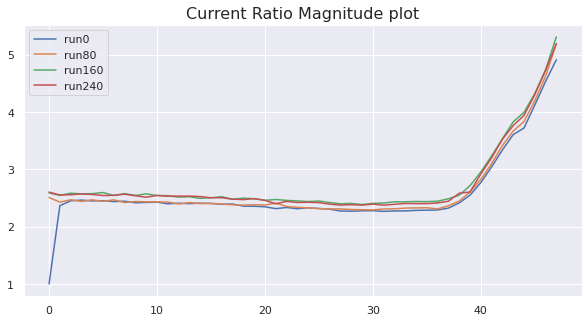

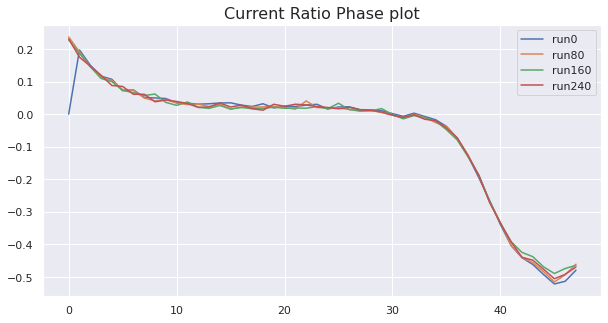

In [ ]:

plot_impedance_characteristics(impedance, 'Current_ratio')

So far there doesn't seem to be any visible trend in battery internal parameters as the battery degrades over time.

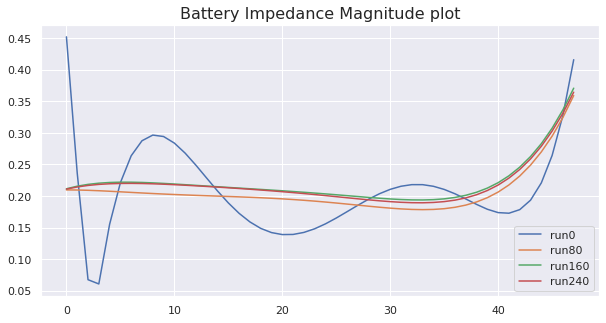

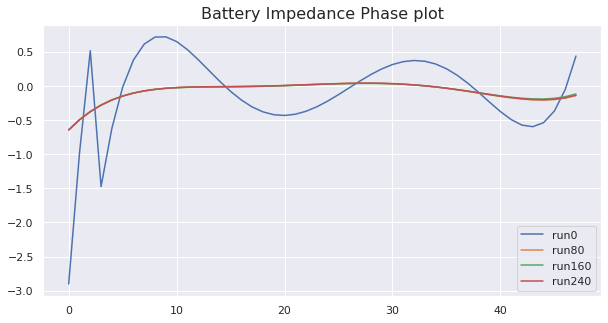

In [ ]:
plot_impedance_characteristics(impedance, 'Battery_impedance')

From the Battery Impedance plots, we observe that with time, the impedance stabilises and doesn't oscillate.

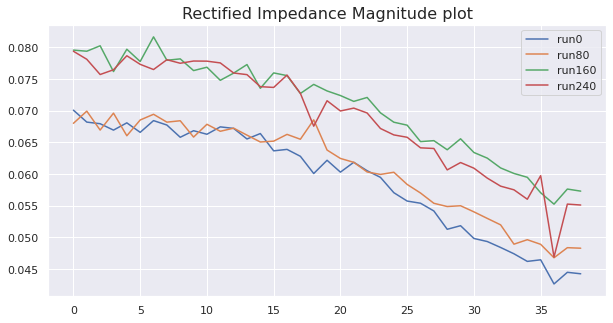

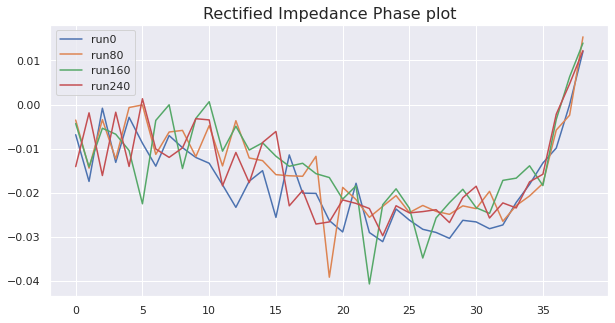

In [ ]:
plot_impedance_characteristics(impedance, 'Rectified_Impedance')

Although the phase plot doesn't have any pertinent features, the magnitude plot shows an increase in rectified impedance as the battery deteriorates.

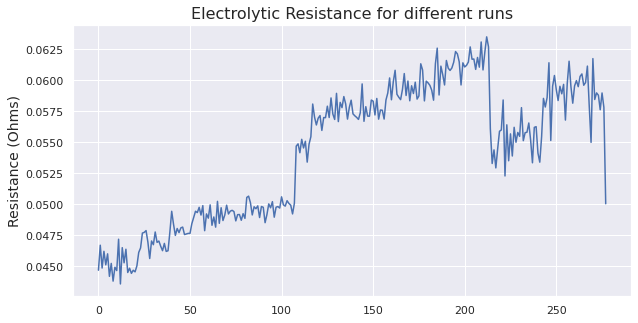

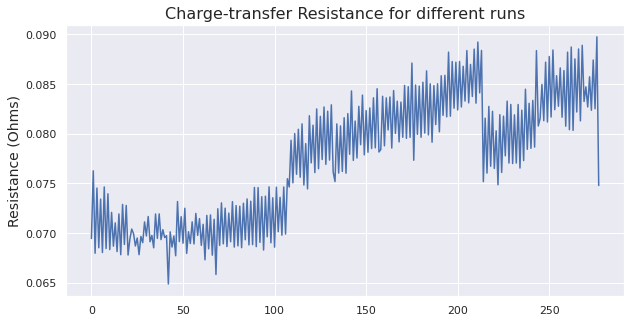

In [ ]:
# Helper function to plot resistances as a function of runs
def plot_resistance(df, key):
  resistance = [impedance.iloc[i]['data'][key] for i in range(len(impedance))]

  labels = {
      'Re': 'Electrolytic Resistance',
      'Rct': 'Charge-transfer Resistance'
  }

  plt.figure(figsize=(10, 5))
  plt.title(f'{labels[key]} for different runs', fontsize=16)
  plt.ylabel('Resistance (Ohms)', fontsize=14)
  plt.plot(resistance)

  plt.show()

# Plot the electrolytic and charge-transfer resistance for different runs
plot_resistance(impedance, 'Re')
plot_resistance(impedance, 'Rct')

Instead of directly trying to analyse Impedance, we adopt a different approach where we try and understand **when** has this data been collected (so far we had been referring to different instants as _runs_ but let's try to understand what this means)

In [ ]:
impedance.index # Print indices for impedance measurements in the original data

Int64Index([ 40,  42,  44,  46,  48,  50,  52,  54,  56,  58,
            ...
            594, 596, 598, 600, 602, 604, 606, 608, 610, 614],
           dtype='int64', length=278)

We 'zoom' in to different points in the dataframe around the impedance measurements.

In [ ]:
print(df[35:50])
print(df[100:115])
print(df[300:315])
print(df[500:515])

         type  ...                                               data
35     charge  ...  {'Voltage_measured': [3.3967166797066484, 3.09...
36  discharge  ...  {'Voltage_measured': [4.188779799856791, 4.188...
37     charge  ...  {'Voltage_measured': [3.3869430085009946, 3.08...
38  discharge  ...  {'Voltage_measured': [4.189272591516219, 4.188...
39     charge  ...  {'Voltage_measured': [3.5795499179382677, 3.23...
40  impedance  ...  {'Sense_current': [(-1+1j), (820.6094970703125...
41  discharge  ...  {'Voltage_measured': [4.187614060563439, 4.186...
42  impedance  ...  {'Sense_current': [(-1+1j), (656.5957641601562...
43     charge  ...  {'Voltage_measured': [3.389085680145772, 3.068...
44  impedance  ...  {'Sense_current': [(-1+1j), (809.5048217773438...
45  discharge  ...  {'Voltage_measured': [4.1876287811083985, 4.18...
46  impedance  ...  {'Sense_current': [(-1+1j), (684.2487182617188...
47     charge  ...  {'Voltage_measured': [3.380743064766377, 3.062...
48  impedance  ...  

We observe that separate impedance measurements are made _after_ charging and _after_ discharging the battery. Let us compare the impedance characteristics after charging and discharing the battery at a particular point.

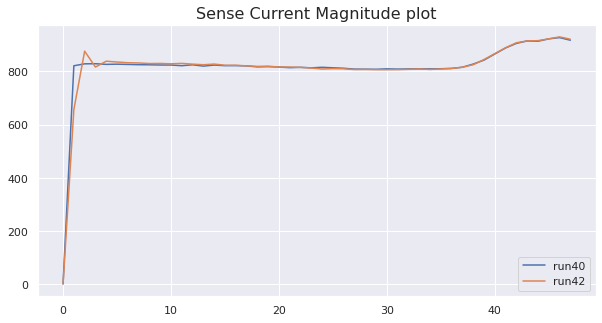

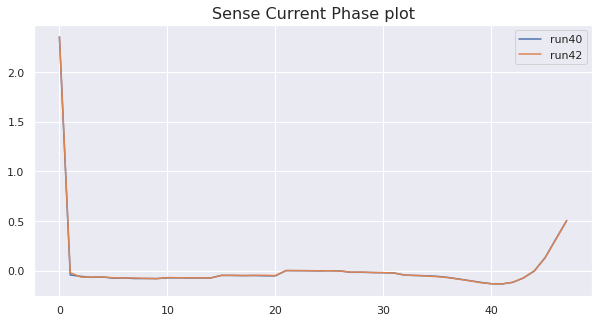

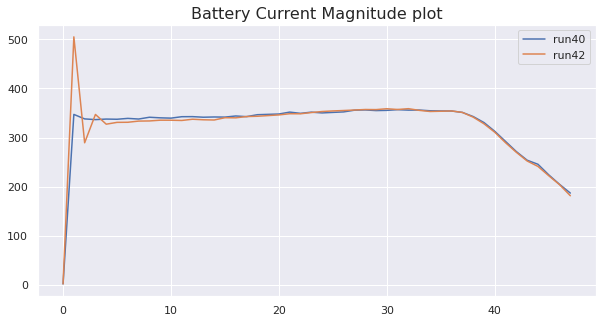

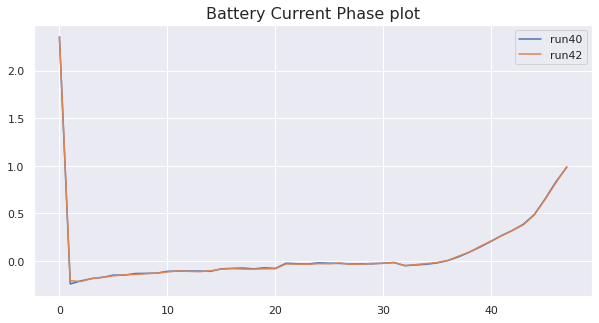

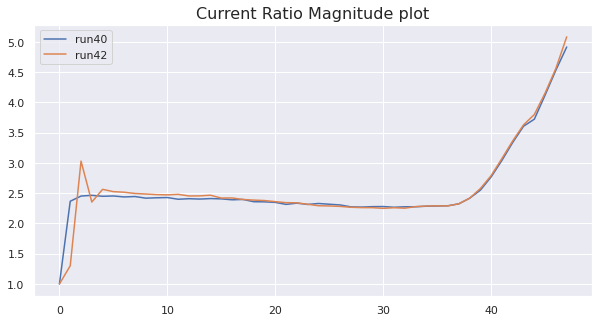

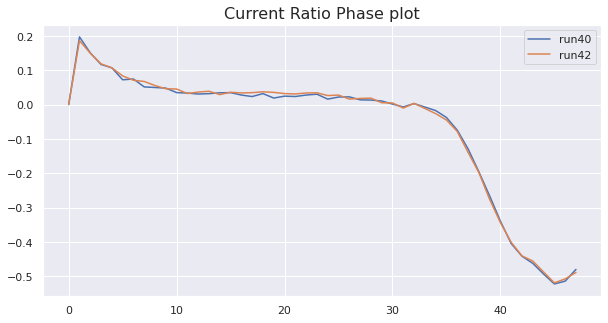

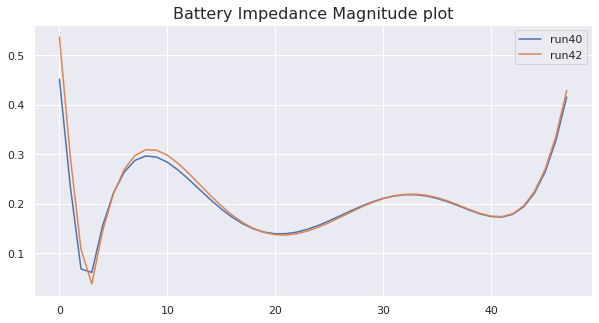

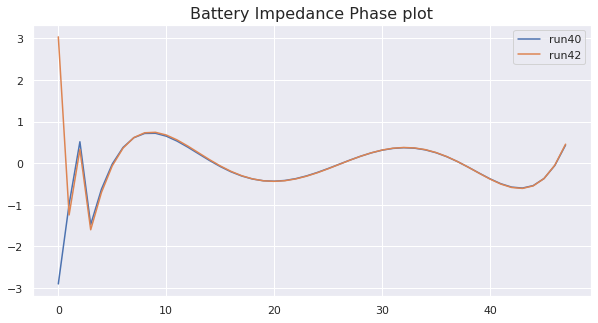

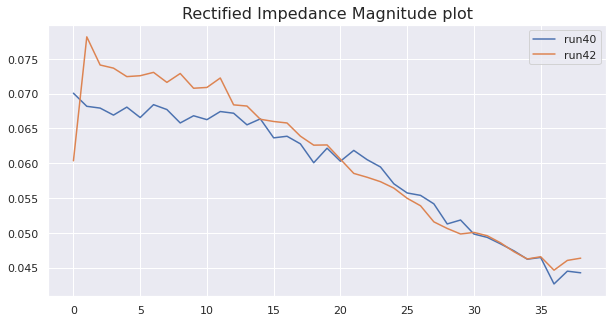

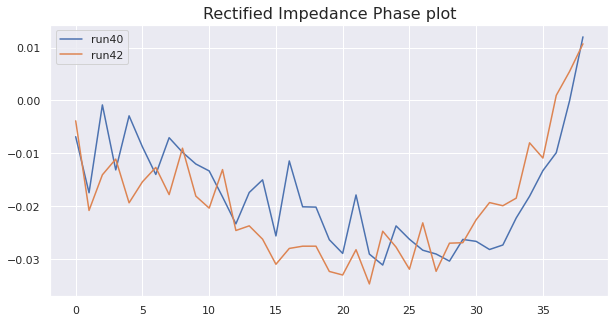

Difference in Electrolytic resistance: -0.002018301258708416
Difference in Charge-transfer resistance: -0.0068184679399359155


In [ ]:
# 40 is an impedance measurement after charging
# 42 is an impedance measurement after discharging
runs = [40, 42] 
keys = ['Sense_current', 'Battery_current', 'Current_ratio', 
        'Battery_impedance', 'Rectified_Impedance']

for key in keys:
  plot_impedance_characteristics(df, key, runs) # Plotting the parameters in keys

# We also print the difference between Re and Rct 
Re_40 = impedance.loc[40]['data']['Re']
Re_42 = impedance.loc[42]['data']['Re']
Rct_40 = impedance.loc[40]['data']['Rct']
Rct_42 = impedance.loc[42]['data']['Rct']
print('Difference in Electrolytic resistance:', Re_40 - Re_42)
print('Difference in Charge-transfer resistance:', Rct_40 - Rct_42)

Nothing seems to stand out from the plots although the electrolytic and charge-transfer resistances have lowered after discharging.

### Discharge Cycle

In [ ]:
# This function plots the data of specified type (voltage, current or temperature)
# for the cycle numbers specified by "cycle_list" argument
def dc_cycle_plots(cell_number, cycle_list, type, figsize = (10,5), only_scatter = False):
    _, discharge, _= split_data(cell_number)

    labels = {'voltage': 'Battery terminal voltage (V)',
              'current': 'Battery output current (A)',
              'temperature': 'Battery temperature (°C)'}
    type_ = type.capitalize() + '_measured'

    plt.figure(figsize = figsize)
    for cycle in cycle_list:
        time_data = discharge.iloc[cycle]['data']['Time']   # List of times obtained from the "discharge" dataframe
        type_data = discharge.iloc[cycle]['data'][type_]    # Data of the type specified, obtained from the "discharge" dataframe
        
        if not only_scatter: plt.plot(time_data, type_data, label = f"cycle {cycle}")
        plt.scatter(time_data, type_data, s = 5)
    plt.title(f"{type.capitalize()} Measured for cell number {cell_number}", fontsize = 14)
    plt.xlabel("Time (seconds)", fontsize = 14)
    plt.ylabel(labels[type], fontsize = 14)
    plt.legend()
    plt.show()

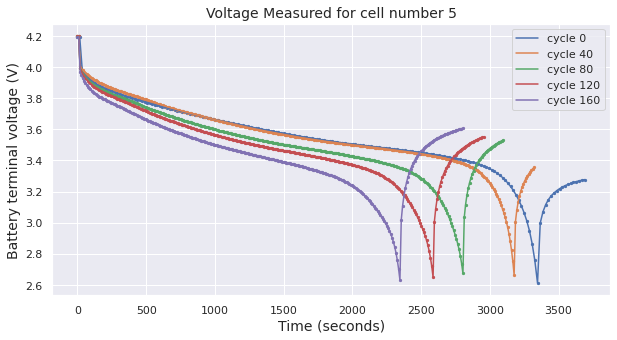

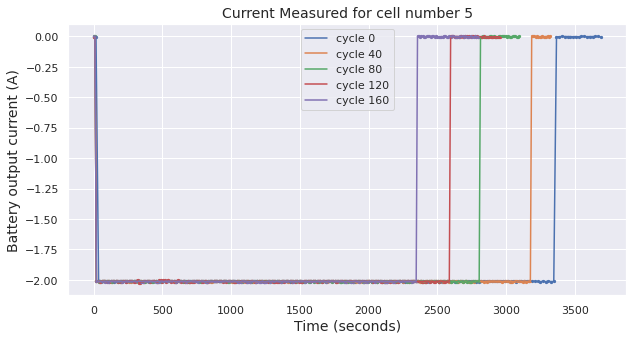

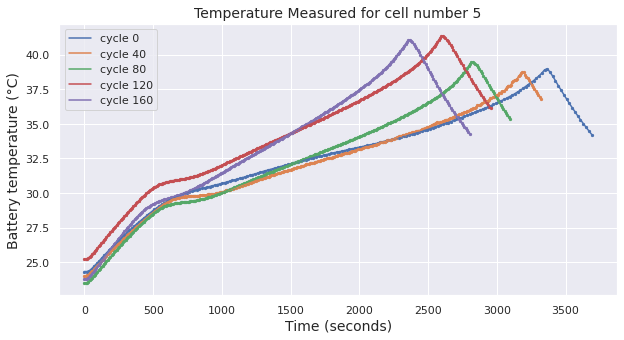

In [ ]:
cycles = [0, 40, 80, 120, 160]
figsize = (10,5)
dc_cycle_plots(5, cycles, 'voltage', figsize = figsize, only_scatter = False)
dc_cycle_plots(5, cycles, 'current', figsize = figsize, only_scatter = False)
dc_cycle_plots(5, cycles, 'temperature', figsize = figsize, only_scatter = False)

In [ ]:
# This function performs the major preprocessing of the data, by picking out the data values 
# which will be used for training out of the complete available data
def preprocessing(cell_number, voltage_splits = 16):
    _, discharge, _ = split_data(cell_number)
    voltages = np.linspace(2.7, 4, voltage_splits)
    
    # features0 stores the Times at which terminal voltage is 2.7, ..., 4
    # features1 stores the Time to reach minimum terminal voltage
    # feature2 stores the Maximum temperature
    # feature3 stores the Time to reach maximum temperature
    
    feature0, feature1, feature2, feature3 = [], [], [], []
    for i in range(len(discharge)):
        time_data = discharge.iloc[i]['data']['Time']                       # Getting time data from the discharge dataframe
        voltage_data = discharge.iloc[i]['data']['Voltage_measured']        # Getting voltage data
        temp_data = discharge.iloc[i]['data']['Temperature_measured']       # Getting temperature data

        times = []
        for j in range(voltage_splits):
            time_for_closest_voltage = time_data[np.argmin(np.abs(voltage_data - voltages[j]))]         # time at which the reading stored in "voltage_data" is closest 
            times.append(time_for_closest_voltage)                                                      # to one of the values in the "voltages" array
        
        feature0 = feature0 + [times]
        feature1.append(time_data[np.argmin(voltage_data)])
        feature2.append(np.max(temp_data))

        time_for_max_temp = time_data[np.argmax(temp_data)]                 # time at which temperature reaches its maximum value
        feature3.append(time_for_max_temp)

    # Using list comprehension: 
    # feature0 = [[discharge.iloc[i]['data']['Time'][np.argmin(np.abs(discharge.iloc[i]['data']['Voltage_measured'] - voltages[j]))] for j in range(len(voltages))] for i in range(len(discharge))]
    # feature1 = [discharge.iloc[i]['data']['Time'][np.argmin(discharge.iloc[i]['data']['Voltage_measured'])] for i in range(len(discharge))]
    # feature2 = [np.max(discharge.iloc[j]['data']['Temperature_measured']) for j in range(len(discharge))]
    # feature3 = [discharge.iloc[j]['data']['Time'][np.argmax(discharge.iloc[j]['data']['Temperature_measured'])] for j in range(len(discharge))]

    x = np.array(feature0)
    feature1 = np.array(feature1)
    feature1 = feature1[:, np.newaxis]

    feature2 = np.array(feature2)
    feature2 = feature2[:, np.newaxis]

    feature3 = np.array(feature3)
    feature3 = feature3[:, np.newaxis]

    x = np.hstack((x, feature1, feature2, feature3))
    y = np.array([discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))])
    
    return x, y

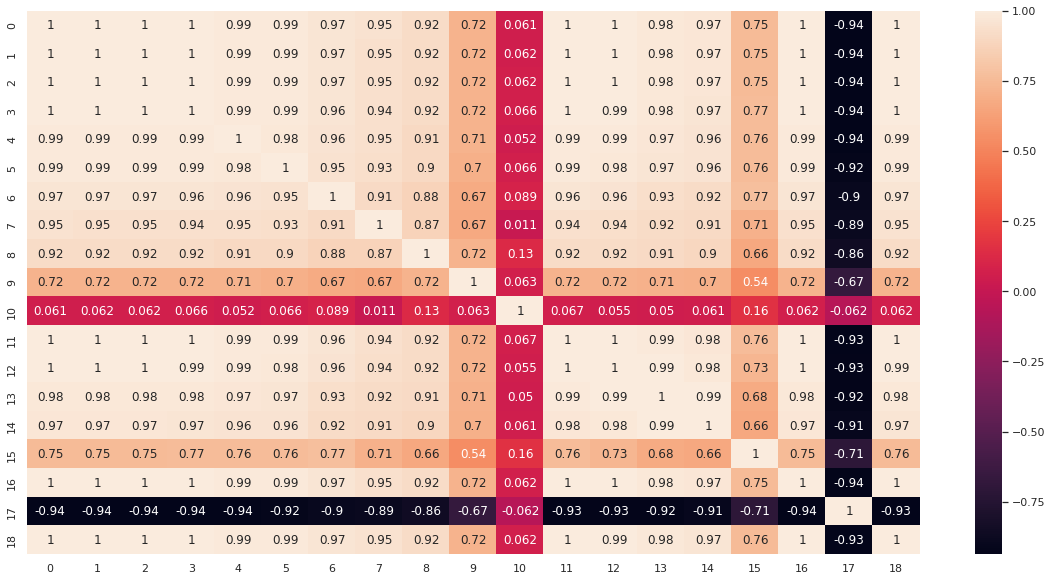

In [ ]:
x, y = preprocessing(5, 16)

# Plot a correlation matrix to determine if there are any redundancies
corr = pd.DataFrame(x).corr()

# Plotting a heatmap between continuous variables
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, 
                 xticklabels=corr.columns,
                 yticklabels=corr.columns,
                 annot=True)

In [ ]:
%%capture
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [ ]:
# Import some additional libraries for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [ ]:
# This function prepares the x and y data for training by performing the test-train split, 
# and applying StandardScaler to normalize the values. The scaler is saved as a global
# variable so that it can be used to obtain the original data by performing inverse_transform
# (if needed)
def prep_for_training(x, y, scale_config = True):
    global scaler
    
    # Split the data in the ratio 80:20 for training, testing respectively
    train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8)

    if scale_config:
        # Standardize the training data
        scaler = StandardScaler()
        # Fit the scaler to X_train
        scaler.fit(train_x)

    # Transform the entire data using the computed mean and variance
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    train = [train_x, train_y]
    test = [test_x, test_y]
    
    return train, test

8 components are sufficient to satisfy the RMSE reconstruction criterion


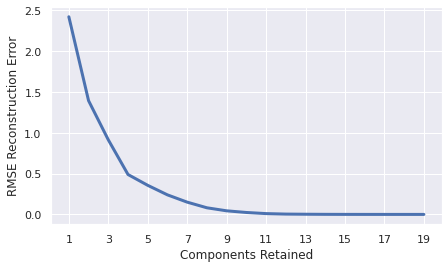

In [ ]:
x, y = preprocessing(5, 16)     # using cell 5 for training
[train_x, train_y], [test_x, test_y] = prep_for_training(x, y)

# Import the module for PCA
from sklearn.decomposition import PCA

# Re-centre the data to have zero mean
X_for_pca = train_x - np.mean(train_x, axis=0)[np.newaxis, :]

# Compute std. deviation of L2 norm input vectors
l2_norm = np.sum(X_for_pca ** 2, axis=-1)
std_dev = np.std(l2_norm)

# Threshold for dimensionality reduction set to 1% of std. deviation
threshold = 0.01 * std_dev

rmse_vs_components = []   # List of RMSE vs n_components for plotting
desired_components = 19   # Start by assuming all components are necessary

# Iterate over number of retained dimensions
for n_components in range(1, 20):
    pca = PCA(n_components=n_components)

    # Fit PCA onto the input data
    pca.fit(X_for_pca)

    # Apply dimensionality reduction on X
    X_transformed = pca.transform(X_for_pca)

    # Transform back to the starting space to compute reconstruction error
    X_projected = pca.inverse_transform(X_transformed)

    # Compute RMSE reconstruction error
    rmse = np.sum((X_for_pca - X_projected) ** 2, axis=-1).mean()

    if rmse < threshold:
        desired_components = min(n_components, desired_components)

    rmse_vs_components.append(rmse)

# Plot RMSE vs Components Retained
plt.figure(figsize=(7, 4))
plt.xlabel('Components Retained', fontsize=12)
plt.ylabel('RMSE Reconstruction Error', fontsize=12)
plt.plot(np.arange(1, 20), rmse_vs_components, lw=3)
plt.xticks(np.arange(1, 20, 2))

print(red(f"{desired_components}", 'bold'), "components are sufficient to satisfy the RMSE reconstruction criterion")

In [ ]:
n_components = desired_components # Sufficient dimensions after compression

# PCA with 8 retained dimensions
pca = PCA(n_components=n_components)
pca.fit(X_for_pca)

train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

# Print the shape for confirmation
print(train_x.shape)
print(test_x.shape) 

(134, 8)
(34, 8)


In [ ]:
from simple_colors import *

# These functions train and evaluate their respective models. Models are saved as 
# global variables so they can be used in the later step of evaluating the model.
# Evaluataion is carried out on completely different cells which the model has not seen

def eval_svr(train, test, training = True):
    global svr

    if training:
        # Define a SVM regressor with a Gaussian kernel
        svr = SVR()

        # Train the model
        svr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
    print(f"R2 Score = {svr.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(svr.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_mlp(train, test, training = True, layer_size = 100, max_iter = 100):
    global mlp
    
    if training: 
        # Define a regressor with 1 hidden layer
        mlp = MLPRegressor(hidden_layer_sizes = (layer_size,), max_iter = max_iter)
        # Train the model
        mlp.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Multi-Layer Perceptron...", 'bold'))
    print(f"R2 Score = {mlp.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(mlp.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_rf(train, test, training = True, n_estimators = 100):
    global regressor
    
    if training:
        # Define a random forest regressor
        regressor = RandomForestRegressor(n_estimators = n_estimators)
        # Train the model
        regressor.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
    print(f"R2 Score = {regressor.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(regressor.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
    
def eval_xgb(train, test, training = True):
    global xgbr
    
    if training:
        # Define a xgb regressor
        xgbr = XGBRegressor()
        # Train the model
        xgbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = xgbr.predict(test[0])
    print(blue(f"Evaluating the XGBoost Regressor...", 'bold'))
    print(f"R2 Score = {metrics.r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_abr(train, test, training = True):
    global abr
    
    if training:
        # Define a adaboost regressor
        abr = AdaBoostRegressor()
        # Train the model
        abr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = abr.predict(test[0])
    print(blue(f"Evaluating the AdaBoost Regressor...", 'bold'))
    print(f"R2 Score = {metrics.r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
    
def eval_lgbmr(train, test, training = True):
    global lgbmr

    if training:
        # Define a LightBGM regressor
        lgbmr = LGBMRegressor()
        # Train the model
        lgbmr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = lgbmr.predict(test[0])
    print(blue(f"Evaluating the LightBGM Regressor...", 'bold'))
    print(f"R2 Score = {metrics.r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_cbr(train, test, training = True):
    global cbr
    
    if training:
        # Define a LightBGM regressor
        cbr = CatBoostRegressor()
        # Train the model
        cbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = cbr.predict(test[0])
    print(blue(f"Evaluating the CatBoost Regressor...", 'bold'))
    print(f"R2 Score = {metrics.r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

In [ ]:
train, test = [train_x, train_y], [test_x, test_y]

eval_svr(train, test, training = True)
eval_rf(train, test, training = True)
eval_xgb(train, test, training = True)
eval_abr(train, test, training = True)
eval_lgbmr(train, test, training = True)
eval_cbr(train, test, training = True)

In [ ]:
# Using an Artificial Neural Network with LSTM and Dense layers
# Importing required libraries
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.utils.vis_utils import plot_model
from tqdm.keras import TqdmCallback

def create_model(plot = False, dpi = 96):
    inputs = Input(shape = (8,1), name = 'Input_features')
    lstm = LSTM(32, input_shape = (8,1))(inputs)
    dense2 = Dense(10)(lstm)
    output = Dense(1, name = 'Output_Layer')(dense2)

    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    if plot: 
        print("Visualizing the model and its layers :")
        display(plot_model(model, show_shapes = True, dpi = dpi))

    return model

def eval_nn(train, test, training = True, plot = True, dpi = 96, ncols = None):
    global nn
    
    if training: train_x = train[0].reshape(-1,8,1)
    test_x = test[0].reshape(-1,8,1)

    if training:
        # Define a LightBGM regressor
        nn = create_model(plot = True, dpi = dpi)
        # Train the model
        nn.fit(train_x, train[1], 
          epochs = 100, 
          batch_size = 1, 
          verbose = 0, 
          callbacks = [TqdmCallback(verbose = 0, ncols = ncols)])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Artificial Neural Network...", 'bold'))
    rmse = nn.evaluate(test_x, test[1])

    print(f"RMSE = {rmse:.4f}")

Visualizing the model and its layers :


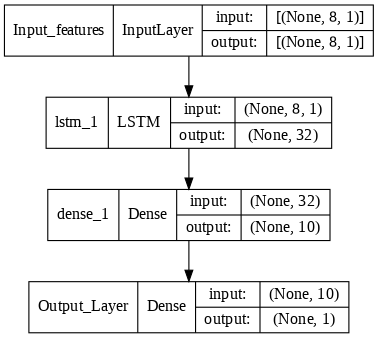

0epoch [00:00, ?epoch/s]

Evaluating the Artificial Neural Network...
2/2 [==============================] - 0s 7ms/step - loss: 3.3014e-04
RMSE = 0.0003


In [ ]:
eval_nn(train, test, training = True, plot = True, dpi = 80)

In [ ]:
# This function applies the previously trained models to the data of other cells
# which have not been used for the training process
def evaluate_cell(cell_number, model_type):
    x, y = preprocessing(cell_number, 16)
    x = scaler.transform(x)
    x = pca.transform(x)

    plt.figure(figsize = (7,5))
    
    if model_type == 'lgbmr' or model_type == 'all': 
        eval_lgbmr(_, [x, y], training = False)
        plt.plot(lgbmr.predict(x), label = "LightGBM Regressor")
    
    if model_type == 'rf' or model_type == 'all':
        eval_rf(_, [x, y], training = False)
        plt.plot(regressor.predict(x), label = "Random Forest Regressor")
    
    if model_type == 'nn' or model_type == 'all':
        eval_nn(_, [x, y], training = False, plot = False)
        plt.plot(nn.predict(x.reshape(-1,8,1)), label = "Artificial Neural Network")
    
    plt.plot(y.reshape(-1,1), label = "True labels")
    plt.legend()
    plt.xlabel("Cycles", fontsize = 14)
    plt.ylabel("Capacity of the battery (Ahr)", fontsize = 14)
    plt.show()

Applying the previously trained models to data from cell 7
Evaluating the LightBGM Regressor...
R2 Score = 0.9797
RMSE = 0.0228


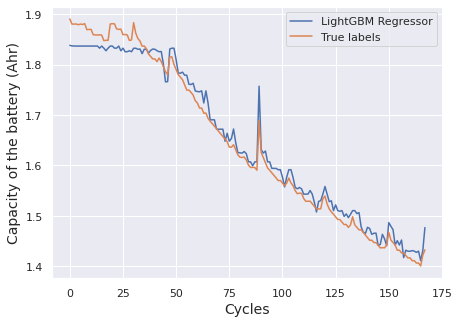

Evaluating the Artificial Neural Network...
6/6 [==============================] - 0s 3ms/step - loss: 2.3940e-04
RMSE = 0.0002


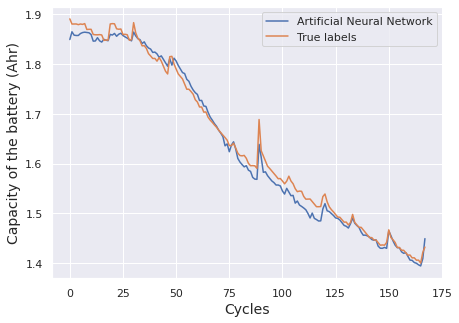

Evaluating the Random Forest Regressor...
R2 Score = 0.9823
RMSE = 0.0213


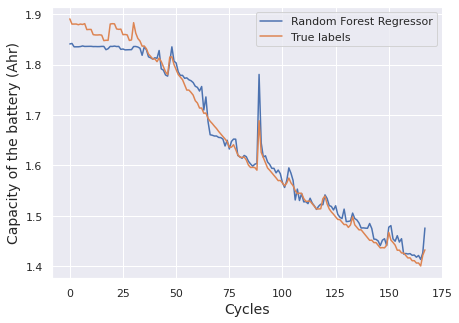

Comparing all models at once
Evaluating the LightBGM Regressor...
R2 Score = 0.9797
RMSE = 0.0228
Evaluating the Random Forest Regressor...
R2 Score = 0.9823
RMSE = 0.0213
Evaluating the Artificial Neural Network...
6/6 [==============================] - 0s 3ms/step - loss: 2.3940e-04
RMSE = 0.0002


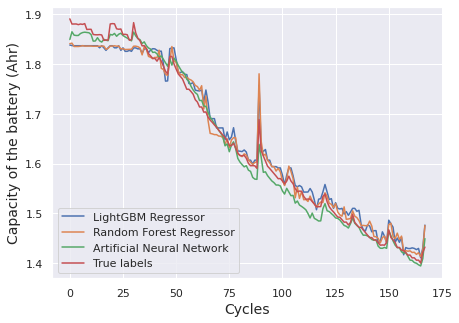

In [ ]:
print(red("Applying the previously trained models to data from cell 7", 'bold'))
evaluate_cell(7, model_type = 'lgbmr')
evaluate_cell(7, 'nn')
evaluate_cell(7, 'rf')

print(red("Comparing all models at once", 'bold'))
evaluate_cell(7, 'all')